In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
from Clustering_Equalgrps.equal_groups import EqualGroupsKMeans

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
M = 16
M_sec = 4
k = int(np.log2(M))
n = 16
TRAINING_SNR = 10 # snr = ebno * k/n
SAMPLE_SIZE = 50000
messages = np.random.randint(M, size=SAMPLE_SIZE)

In [3]:
one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(M)])
data_oneH = one_hot_encoder.fit_transform(messages.reshape(-1, 1))

# Generate Training Data
#x = tf.random.uniform(shape=[SAMPLE_SIZE], minval=0, maxval=M, dtype=tf.int64)
#x_1h = tf.one_hot(x, M)
#dataset = tf.data.Dataset.from_tensor_slices(x_1h)

In [4]:
def snr_to_noise(snrdb):
    '''Transform snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr) # 1/np.sqrt(2*(k/n)*ebno) for ebno to noise
    return noise_std

In [5]:
noise_std = snr_to_noise(TRAINING_SNR)
noise_std_eve = snr_to_noise(7)

# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))
channel_layer = keras.layers.Lambda(lambda x: 
                    tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
channel_layer_eve = keras.layers.Lambda(lambda x: 
                    tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std_eve)))

encoder = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=[M]),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(2*n, activation=None),
            shape_layer,
            norm_layer])

channel = keras.models.Sequential([channel_layer])
channel_eve = keras.models.Sequential([channel_layer, channel_layer_eve])

decoder_bob = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[2,n]),
                shape_layer2,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])

decoder_eve = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[2,n]),
                shape_layer2,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])

autoencoder_bob = keras.models.Sequential([encoder, channel, decoder_bob])
autoencoder_eve = keras.models.Sequential([encoder, channel_eve, decoder_eve])

In [6]:
def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [7]:
def random_batch(X, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size) 
    return X[idx]

In [8]:
def test_encoding(M=16, n=1):
    inp = np.eye(M, dtype=int)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [9]:
def test_noisy_codeword(data):
    rcvd_word = data[1:2000]
    fig = plt.figure(figsize=(4,4))
    plt.plot(rcvd_word[:,0], rcvd_word[:, 1], "b.")
    #plt.plot(rcvd_word_eve[:,0], rcvd_word_eve[:, 1], 'or')    
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [10]:
n_epochs = 5
batch_size = 200
n_steps = len(data_oneH) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.005)
loss_fn = keras.losses.categorical_crossentropy
mean_loss = keras.metrics.Mean()

In [11]:
def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
    if step % 10 == 0:
        print(template.format(step, epoch, mean_loss.result(), B_Ber(X_batch, y_pred)))
        if plot_encoding:
            test_encoding()

In [12]:
def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), B_Ber(X_batch, y_pred)))

In [13]:
def train_Bob(n_epochs=5, n_steps=20, plot_encoding=True, only_decoder=False):
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_batch(data_oneH, batch_size) 
            #X_batch  = dataset.batch(batch_size)
            with tf.GradientTape() as tape:
                y_pred = autoencoder_bob(X_batch, training=True)
                main_loss = tf.reduce_mean(loss_fn(X_batch, y_pred))
                loss = main_loss
            if only_decoder:
                gradients = tape.gradient(loss, decoder_bob.trainable_variables) 
                optimizer.apply_gradients(zip(gradients, decoder_bob.trainable_variables)) 
            else:
                gradients = tape.gradient(loss, autoencoder_bob.trainable_variables) 
                optimizer.apply_gradients(zip(gradients, autoencoder_bob.trainable_variables)) 
            mean_loss(loss)
            plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)
        plot_batch_loss(epoch, mean_loss, X_batch, y_pred)

In [14]:
def train_Eve(n_epochs=5, iterations=20, plot_encoding=True):
    for epoch in range(1, n_epochs + 1): 
        print("Training Eve in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_batch(data_oneH, batch_size) 
            with tf.GradientTape() as tape:
                y_pred = autoencoder_eve(X_batch, training=True)
                main_loss = tf.reduce_mean(loss_fn(X_batch, y_pred))
                loss = main_loss
            gradients = tape.gradient(loss, decoder_eve.trainable_variables) 
            optimizer.apply_gradients(zip(gradients, decoder_eve.trainable_variables)) 
            mean_loss(loss)
            plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)
        plot_batch_loss(epoch, mean_loss, X_batch, y_pred)

In [15]:
def init_kmeans(symM=16, satellites=4, n=100):
    '''Initializes equal sized clusters with the whole message set'''
    inp = np.eye(symM, dtype=int)
    unit_codewords = encoder.predict(inp)
    kmeans = EqualGroupsKMeans(n_clusters=satellites)
    kmeans.fit(unit_codewords.reshape(symM,2*n))
    return kmeans

In [16]:
def generate_mat(kmeans_labels, satellites=4, symM=16):
    '''Generates the matrix for equalization of the input distribution on Eves side'''
    gen_matrix = np.zeros((symM,symM))
    for j in range(satellites):
        for i in range(symM):
            if kmeans_labels[i]==j:
                for k in range(symM):
                    if kmeans_labels[k] == j:
                        gen_matrix[i,k] = 1/satellites;
    gen_mat=tf.cast(gen_matrix, tf.float64)
    return gen_mat

In [17]:
def train_Secure(kmeans_labels, n_epochs=5, iterations=20, alpha=0.7, plot_encoding=True):
    '''This procedure trains the encoder to cluster the codewords,
       based on the kmeans labels.
       
       Inputs: kmeans.labels_, epochs, iterations, alpha, plotting decision variable
    '''
    generator_matrix = generate_mat(kmeans_labels, M_sec, M)
    for epoch in range(1, n_epochs + 1): 
        print("Training for Security in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_batch(data_oneH, batch_size)
            x_batch_s= tf.matmul(X_batch, generator_matrix)
            with tf.GradientTape() as tape:
                y_pred_bob = autoencoder_bob(X_batch, training=True)
                y_pred_eve = autoencoder_eve(X_batch, training=False)
                loss_bob = tf.reduce_mean(loss_fn(X_batch, y_pred_bob))    
                loss_eve = tf.reduce_mean(loss_fn(x_batch_s, y_pred_eve))
                loss_sec =  (1-alpha)*loss_bob + alpha*loss_eve
            gradients = tape.gradient(loss_sec, autoencoder_bob.trainable_variables) 
            optimizer.apply_gradients(zip(gradients, autoencoder_bob.trainable_variables)) 
            mean_loss(loss_sec)
            plot_loss(step, epoch, mean_loss, X_batch, y_pred_bob, plot_encoding)
        plot_batch_loss(epoch, mean_loss, X_batch, y_pred_bob)

In [18]:
# test msg sequence for normal encoding
N_test = 150000
test_msg = np.random.randint(M, size=N_test)
one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(M)])
data_oh_normal = one_hot_encoder.fit_transform(test_msg.reshape(-1,1))

In [19]:
def Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    bber_vec_eve = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(7)
        code_word = encoder.predict(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        rcvd_word_eve = rcvd_word + \
                            tf.random.normal(tf.shape(rcvd_word), mean=0.0, stddev=noise_std_eve)
        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)
        bber_vec_bob[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve[db] = B_Ber(data, dcoded_msg_eve)
        print(f'Progress: {db+1} of {30} parts')
        #test_noisy_codeword(rcvd_word)
        #test_noisy_codeword(rcvd_word_eve)
    return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)

In [20]:
def satellite_labels(kmeans_labels, data_label, sats=8, data_size=150000):
    '''Generate cloud/satelite codewords which utilizes the previously trained encoder.
       It therefore takes a message vector of lower dimensionality and maps it to the higher
       dimensional secure coding. The satelite codewords, i.e. co-sets are chosen randomly
       according to the clusters.
    '''
    code_mat = np.zeros((sats, sats))
    for sat in range(sats):
        n = 0;
        for index in range(M):
            if kmeans_labels[index] == sat:
                code_mat[sat, n] = index;
                n = n + 1;
    coded_label = np.zeros(data_size)
    for i in range(data_size):
        aux_var = data_label[i];
        # pick a random row of column aux_var, i.e random symbol in the cluster
        coded_label[i] = code_mat[np.random.randint(M_sec), aux_var];
        
    return coded_label, code_mat

In [21]:
def sec_decoding(code_mat, pred_output, satellites, clusters):
    '''Decodes the cloud signal encoding'''
    sats = satellites
    data = np.array(pred_output)
    decoded_data = np.zeros(len(data))
    for sample in range(len(data)):
        cloud, msg = np.where(code_mat == data[sample])
        decoded_data[sample] = msg
    return decoded_data

In [22]:
def Test_secure_AE(coded_data, code_mat, real_data):
    '''Calculate symbol error for varying SNRs'''
    snr_range = np.linspace(0, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    bber_vec_eve = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(7)
        code_word = encoder.predict(coded_data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        rcvd_word_eve = rcvd_word + \
                            tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve)
        pred_msg_bob = decoder_bob.predict(rcvd_word)
        pred_msg_eve = decoder_eve.predict(rcvd_word_eve)
        decoded_msg_bob = sec_decoding(code_mat, np.array(tf.argmax(pred_msg_bob,1)),
                                    M_sec, M_sec)
        decoded_msg_eve = sec_decoding(code_mat, np.array(tf.argmax(pred_msg_eve,1)),
                                    M_sec, M_sec)
        bber_vec_bob[db] = np.mean(np.not_equal(decoded_msg_bob, real_data))
        bber_vec_eve[db] = np.mean(np.not_equal(decoded_msg_eve, real_data))
        print(f'Progress: {db+1} of {30} parts')
        #test_noisy_codeword(rcvd_word)
        #test_noisy_codeword(rcvd_word_eve)
    return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)

In [23]:
train_Bob(n_epochs, n_steps, False, False)
train_Eve(n_epochs-1, n_steps, False) #reduced epochs to match accuracy of both
bber_data_bob, bber_data_eve = Test_AE(data_oh_normal) # Taking test data for comparison

kmeans = init_kmeans(M,M_sec,n) # Initlizing kmeans for the security procedure
train_Secure(kmeans.labels_, n_epochs-3, n_steps, 0.3, False)
train_Bob(n_epochs-2, n_steps, False, True)
train_Eve(n_epochs-3, n_steps, False)

# test msg sequence for secure encoding
N_test_sec = 150000
test_msg_sec = np.random.randint(M_sec, size=N_test_sec)
print('Mapping real symbols onto secure symbols')
coded_msg, code_matrix = satellite_labels(kmeans.labels_, test_msg_sec,
                                          M_sec, N_test_sec)
one_hot_encoder_sec = OneHotEncoder(sparse=False, categories=[range(M)])
data_oh_sec = one_hot_encoder_sec.fit_transform(coded_msg.reshape(-1,1))
print("Testing the secure symbols")
bber_sec_bob, bber_sec_eve = Test_secure_AE(data_oh_sec, code_matrix, test_msg_sec)


Training Bob in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: 2.42142, Batch_BER: 0.41000
Iteration: 20, Epoch: 1, Loss: 1.82049, Batch_BER: 0.00000
Iteration: 30, Epoch: 1, Loss: 1.37991, Batch_BER: 0.00000
Iteration: 40, Epoch: 1, Loss: 1.08505, Batch_BER: 0.00000
Iteration: 50, Epoch: 1, Loss: 0.88690, Batch_BER: 0.00000
Iteration: 60, Epoch: 1, Loss: 0.74830, Batch_BER: 0.00000
Iteration: 70, Epoch: 1, Loss: 0.64659, Batch_BER: 0.00000
Iteration: 80, Epoch: 1, Loss: 0.56912, Batch_BER: 0.00000
Iteration: 90, Epoch: 1, Loss: 0.50813, Batch_BER: 0.00000
Iteration: 100, Epoch: 1, Loss: 0.45898, Batch_BER: 0.00000
Iteration: 110, Epoch: 1, Loss: 0.41855, Batch_BER: 0.00000
Iteration: 120, Epoch: 1, Loss: 0.38467, Batch_BER: 0.00000
Iteration: 130, Epoch: 1, Loss: 0.35584, Batch_BER: 0.00000
Iteration: 140, Epoch: 1, Loss: 0.33105, Batch_BER: 0.00000
Iteration: 150, Epoch: 1, Loss: 0.30951, Batch_BER: 0.00000
Iteration: 160, Epoch: 1, Loss: 0.29058, Batch_BER: 0.00000
Iteration: 170, Epoch: 

Iteration: 60, Epoch: 1, Loss: 0.04269, Batch_BER: 0.00000
Iteration: 70, Epoch: 1, Loss: 0.04238, Batch_BER: 0.00000
Iteration: 80, Epoch: 1, Loss: 0.04208, Batch_BER: 0.00000
Iteration: 90, Epoch: 1, Loss: 0.04177, Batch_BER: 0.00000
Iteration: 100, Epoch: 1, Loss: 0.04147, Batch_BER: 0.00000
Iteration: 110, Epoch: 1, Loss: 0.04118, Batch_BER: 0.00000
Iteration: 120, Epoch: 1, Loss: 0.04089, Batch_BER: 0.00000
Iteration: 130, Epoch: 1, Loss: 0.04060, Batch_BER: 0.00000
Iteration: 140, Epoch: 1, Loss: 0.04031, Batch_BER: 0.00000
Iteration: 150, Epoch: 1, Loss: 0.04003, Batch_BER: 0.00000
Iteration: 160, Epoch: 1, Loss: 0.03976, Batch_BER: 0.00000
Iteration: 170, Epoch: 1, Loss: 0.03948, Batch_BER: 0.00000
Iteration: 180, Epoch: 1, Loss: 0.03921, Batch_BER: 0.00000
Iteration: 190, Epoch: 1, Loss: 0.03895, Batch_BER: 0.00000
Iteration: 200, Epoch: 1, Loss: 0.03868, Batch_BER: 0.00000
Iteration: 210, Epoch: 1, Loss: 0.03842, Batch_BER: 0.00000
Iteration: 220, Epoch: 1, Loss: 0.03817, Bat

Iteration: 250, Epoch: 1, Loss: 0.08828, Batch_BER: 0.00000
Interim result for Epoch: 1, Loss: 0.08828, Batch_BER: 0.00000
Training for Security in Epoch 2/2
Iteration: 10, Epoch: 2, Loss: 0.09027, Batch_BER: 0.00000
Iteration: 20, Epoch: 2, Loss: 0.09224, Batch_BER: 0.00000
Iteration: 30, Epoch: 2, Loss: 0.09421, Batch_BER: 0.00000
Iteration: 40, Epoch: 2, Loss: 0.09614, Batch_BER: 0.00000
Iteration: 50, Epoch: 2, Loss: 0.09806, Batch_BER: 0.00000
Iteration: 60, Epoch: 2, Loss: 0.09996, Batch_BER: 0.00000
Iteration: 70, Epoch: 2, Loss: 0.10185, Batch_BER: 0.00000
Iteration: 80, Epoch: 2, Loss: 0.10372, Batch_BER: 0.00000
Iteration: 90, Epoch: 2, Loss: 0.10558, Batch_BER: 0.00000
Iteration: 100, Epoch: 2, Loss: 0.10743, Batch_BER: 0.00000
Iteration: 110, Epoch: 2, Loss: 0.10928, Batch_BER: 0.00500
Iteration: 120, Epoch: 2, Loss: 0.11109, Batch_BER: 0.00000
Iteration: 130, Epoch: 2, Loss: 0.11288, Batch_BER: 0.00000
Iteration: 140, Epoch: 2, Loss: 0.11465, Batch_BER: 0.00000
Iteration: 

Iteration: 40, Epoch: 2, Loss: 0.10579, Batch_BER: 0.01000
Iteration: 50, Epoch: 2, Loss: 0.10564, Batch_BER: 0.02500
Iteration: 60, Epoch: 2, Loss: 0.10546, Batch_BER: 0.01500
Iteration: 70, Epoch: 2, Loss: 0.10530, Batch_BER: 0.01000
Iteration: 80, Epoch: 2, Loss: 0.10514, Batch_BER: 0.01000
Iteration: 90, Epoch: 2, Loss: 0.10497, Batch_BER: 0.02000
Iteration: 100, Epoch: 2, Loss: 0.10479, Batch_BER: 0.00500
Iteration: 110, Epoch: 2, Loss: 0.10461, Batch_BER: 0.01500
Iteration: 120, Epoch: 2, Loss: 0.10445, Batch_BER: 0.00500
Iteration: 130, Epoch: 2, Loss: 0.10428, Batch_BER: 0.00000
Iteration: 140, Epoch: 2, Loss: 0.10414, Batch_BER: 0.01500
Iteration: 150, Epoch: 2, Loss: 0.10396, Batch_BER: 0.01000
Iteration: 160, Epoch: 2, Loss: 0.10381, Batch_BER: 0.02000
Iteration: 170, Epoch: 2, Loss: 0.10367, Batch_BER: 0.01500
Iteration: 180, Epoch: 2, Loss: 0.10349, Batch_BER: 0.01000
Iteration: 190, Epoch: 2, Loss: 0.10333, Batch_BER: 0.01500
Iteration: 200, Epoch: 2, Loss: 0.10317, Batch

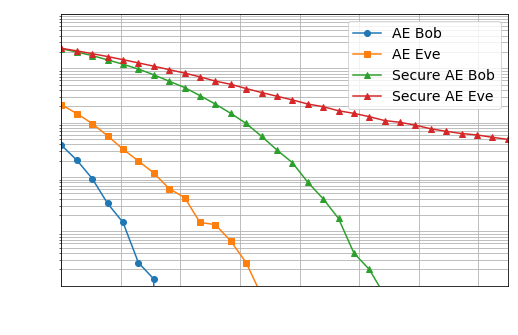

In [24]:
fig = plt.figure(figsize=(8, 5))
plt.semilogy(bber_data_bob[0], bber_data_bob[1], 'o-')
plt.semilogy(bber_data_eve[0], bber_data_eve[1], 's-')
plt.semilogy(bber_sec_bob[0], bber_sec_bob[1], '^-');
plt.semilogy(bber_sec_eve[0], bber_sec_eve[1], '^-');

plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90, color='white')
plt.xlabel("SNR [dB]", fontsize=18, color='white')
plt.legend(['AE Bob', 'AE Eve', 'Secure AE Bob', 'Secure AE Eve'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")